## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространенная проблема фитнес-клубов и других сервисов — это отток клиентов. Индикаторы оттока зависят от специфики отрасли. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевел в электронный вид множество анкет пользователей и обратился за помощью к нам.

**Цель проекта**: провести анализ и подготовить план действий по удержанию клиентов. 

**Задачи**:

I. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

II. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

III. проанализировать основные признаки, наиболее сильно влияющие на отток;

IV. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1. выделить целевые группы клиентов;

2. предложить меры по снижению оттока;

3. определить другие особенности взаимодействия с клиентами.

**Описание данных**

Заказчик подготовил для нас файл, который содержит данные на месяц до оттока и факт оттока на определенный месяц. Набор данных включает следующие поля:

1. Данные клиента за предыдущий до проверки факта оттока месяц:
* gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнера клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* Churn — факт оттока в текущем месяце.

## Шаг 1. Загрузим данные и подготовим их к анализу

**Импортируем необходимые библиотеки для исследования**

In [1]:
import pandas as pd
import numpy as np
import math as mth

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans 
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

**Прочитаем данные из файлов и сохраним их**

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

**С помощью pd.option настроим вывод так, чтобы текст в ячейке отражался полностью вне зависимости от длины, числа отражались с двумя знаками после запятой**

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:.2f}'.format

**Посмотрим содержимое таблицы gym_churn, выведем общую информацию и проверим наши данные на наличие нулевых объектов, пропусков и дубликатов**

In [4]:
def total_info(df, name_list):
    print('\033[1m' + 'Первые 5 строк таблицы', name_list + '\033[0m')
    display(df.head(5))
    
    print('\033[1m' + 'Общая информация таблицы', name_list + '\033[0m')
    display(df.info())
    
    print('\033[1m' + 'Наличие пропусков в таблице', name_list + '\033[0m')
    display(df.isna().sum())
    
    print('\033[1m' + 'Hаличие дубликатов в таблице', name_list + '\033[0m')
    display(df.duplicated().sum())
    
total_info(gym_churn, 'gym_churn')

Первые 5 строк таблицы gym_churn


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Общая информация таблицы gym_churn
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_t

None

Наличие пропусков в таблице gym_churn


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Hаличие дубликатов в таблице gym_churn


0

* Всего в таблице 4000 строк (наблюдений) и 14 столбцов, встречаются следующие типы данных: int64 (целые числа) и float64 (вещественные числа).
* Пропусков и дубликатов не обнаружили. 
* Приведем столбцы к нижнему регистру, а в столбце month_to_end_contract переведем значения с плавающей точкой в целое число.

**Приведем столбцы к нижнему регистру и заменим тип данных в столбце month_to_end_contract**

In [5]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('int')

Теперь данные готовы для дальнейшего анализа.

**Вывод**

У нас есть данные клиентов за предыдущий до проверки факта оттока месяц, информация на основе журнала посещений, покупок, а также информация о текущем статусе абонемента.

Данные представлены в виде таблицы, включающей в себя 4000 строк и 14 столбцов, в которых содержится следующая информация: пол, факт проживания или работы в районе, где находится фитнес-центр, выделение сотрудников компании-партнера клуба. факт первоначальной записи в рамках акции «приведи друга», наличие контактного телефона, информации о возрасте, времени с момента первого обращения в фитнес-центр, длительности текущего действующего абонемента, срока до окончания текущего действующего абонемента, факта посещения групповых занятий, средней частоты посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарной выручки от других услуг фитнес-центра и факта оттока в текущем месяце.

На этапе подготовки данных названия столбцов в таблице были приведены к нижнему регистру, был изменен тип данных столбца с информацией о сроке до окончания текущего действующего абонемента. Пропусков и дубликатов в данных не обнаружено.

## Шаг 2. Проведем исследовательский анализ данных (EDA)

### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

Вызовем метод describe() и посмотрим на  параметры загруженных данных. Для удобства отображения поменяем местами столбцы и строки.

Обратим внимание на общие статистики показателей в данных:
* count - количество значений, которые не являются пропущенными;
* mean, std - среднее и разброс данных в соответствующем поле;
* остальные статистики - минимальное и максимальное значения, квантили.

In [6]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


* Почти одинаковое распределение по полу (gender).
* 85% клиентов проживают или работают в районе, где находится фитнес-центр (near_location).
* 49% клиентов являются сотрудниками компании-партнера клуба (partner).
* 31% клиентов пришли по программе «приведи друга» (promo_friends).
* Контактный телефон указан у 90% клиентов (phone).
* Средняя длительность текущего действующего абонемента 4.6 месяца (contract_period).
* 41% клиентов посещают групповые занятия (group_visits).
* Средний возраст клиентов 29 лет (age).
* Средняя суммарная выручка от других услуг фитнес-центра 147 у.е. (avg_additional_charges_total).
* Средний срок до окончания текущего действующего абонемента 4.3 месяца (month_to_end_contract).
* Среднее время с момента первого обращения в фитнес-центр 3.7 месяца (lifetime).
* Средняя частота посещений в неделю за все время с начала действия абонемента 1.8 раз (avg_class_frequency_total).
* Средняя частота посещений в неделю за предыдущий месяц 1.7 раз (avg_class_frequency_current_month).
* Доля оттока 27%. Значит, в нашей выборке только 27% клиентов ушли из сети фитнес-центров (churn).

В датасете нет отсутствующих признаков.

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуемся методом groupby()). Оставшиеся клиенты - 0, ушли в отток - 1

In [7]:
gym_churn_mean = gym_churn.groupby('churn').agg('mean').T
gym_churn_mean

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


* Одинаковое распределение по полу.
* Реже попадают в отток клиенты, которые проживают или работают ближе к фитнес-центру.
* Сотрудники компаний-партнеров реже перестают посещать фитнес-клуб чем остальные клиенты.
* Клиенты пришедшие по акции «приведи друга», почти в два раза реже уходят в отток.
* Наличие контактного телефона клиента не отличается в группах.
* Средняя длительность действующего абонемента у клиентов, которые уходят в отток, намного меньше, чем у оставшихся.
* Клиенты, которые уходят в отток меньше посещают групповые занятия (хотя возможно, что в отток попали те, кто не успел начать ходить на них).
* Клиенты, которые уходят в отток, младше возрастом, чем те, кто остается.
* У клиентов, которые ушли в отток меньше значение средней суммарной выручки от других услуг фитнес-центра (кафе, спорттовары, косметический и массажный салон).
* Средний срок до окончания текущего действующего абонемента у тех, кто ушел в отток, меньше.
* Средняя частота посещений в неделю за предыдущий месяц и посещений в неделю за все время меньше у тех, кто ушел в отток.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

**Посмотрим, как соотносятся классы для нашего набора данных**

In [8]:
gym_churn['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

**Построим гистограммы и распределения признаков для тех, кто ушел (отток) и тех, кто остался (не попали в отток)**

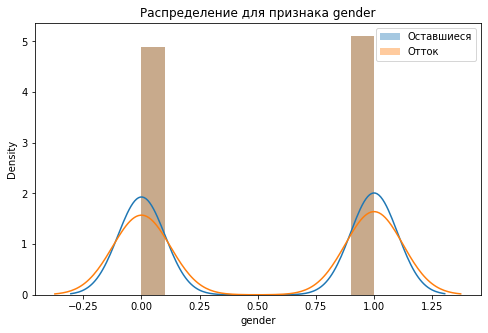

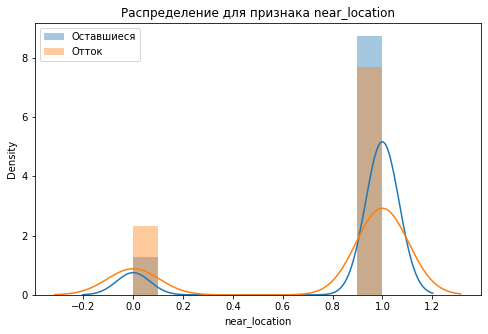

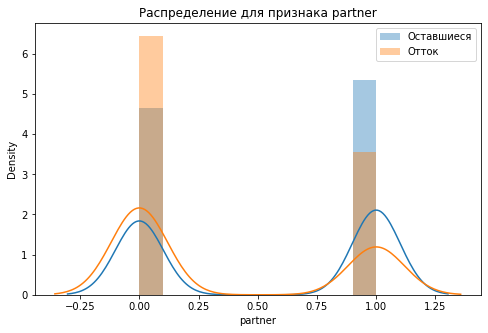

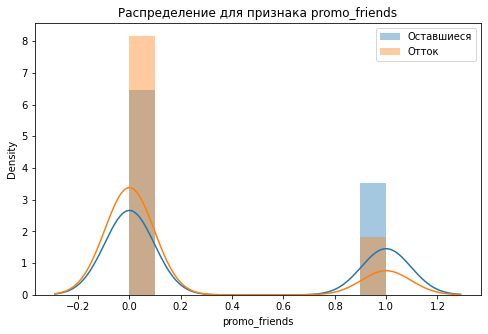

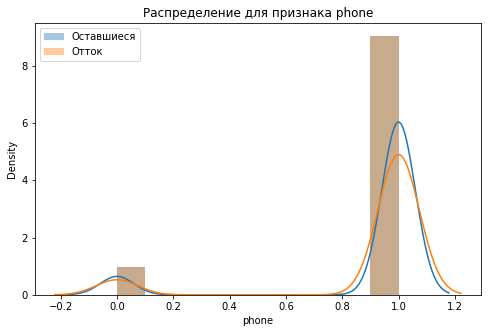

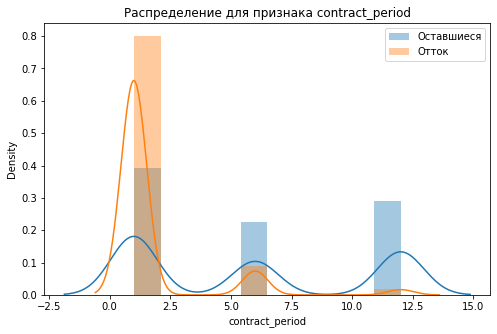

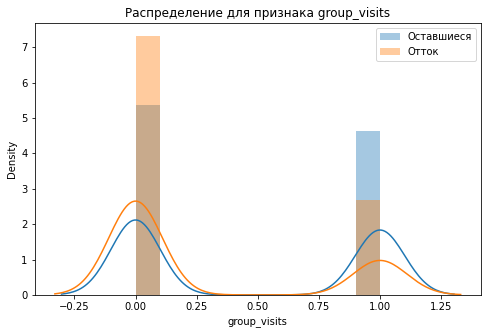

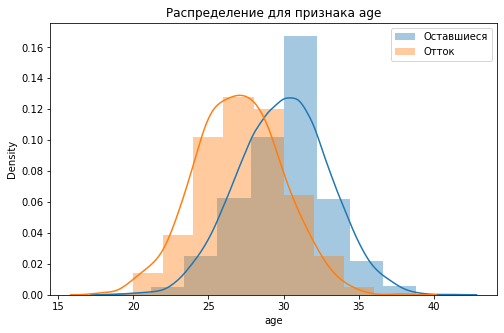

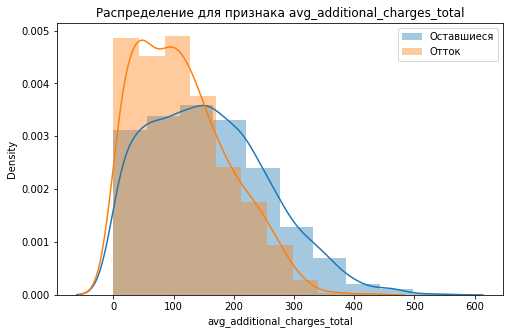

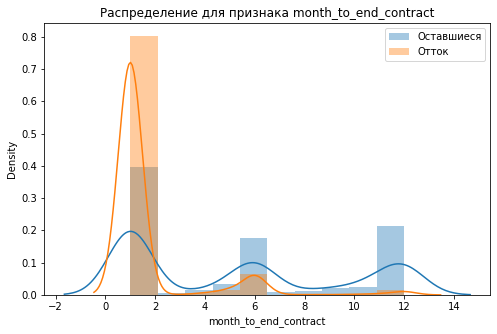

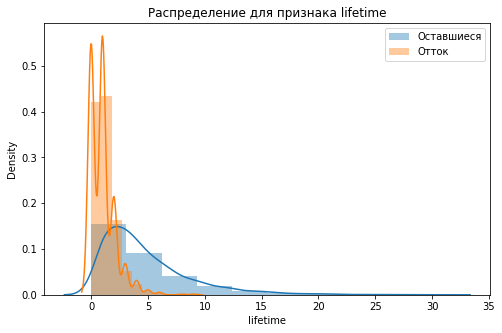

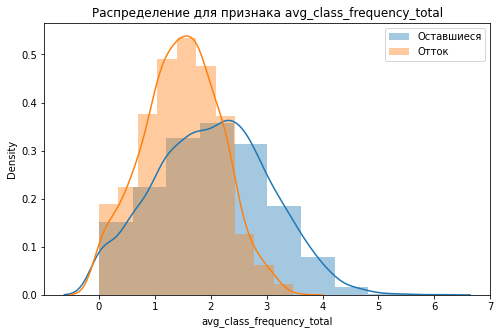

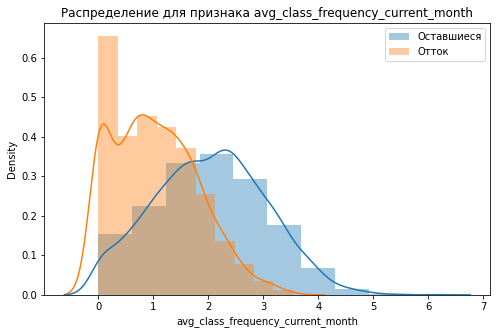

In [9]:
# создадим два датасета с разделением по ключевому признаку сhurn, где 0 - оставшиеся клиенты; 1 - отток
gym_churn_0 = gym_churn[gym_churn['churn']==0].reset_index(drop=True).drop('churn', axis=1)
gym_churn_1 = gym_churn[gym_churn['churn']==1].reset_index(drop=True).drop('churn', axis=1)

# напишем цикл для создания гистограмм
for feature in gym_churn_0.columns:
    plt.figure(figsize=(8,5))
    plt.title("Распределение для признака " + feature)
    sns.distplot(gym_churn_0[feature], bins = 10, label="Оставшиеся")
    sns.distplot(gym_churn_1[feature], bins = 10, label="Отток")
    plt.legend()
    plt.show()

**Напишем цикл для построения графиков для количественных признаков**

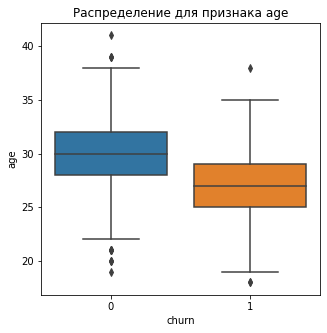

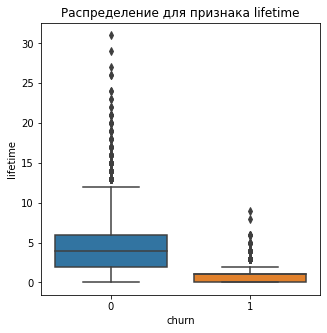

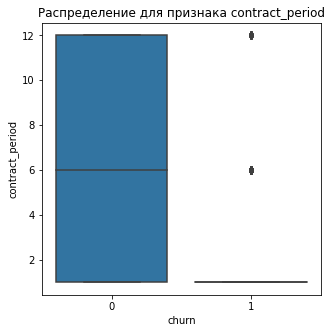

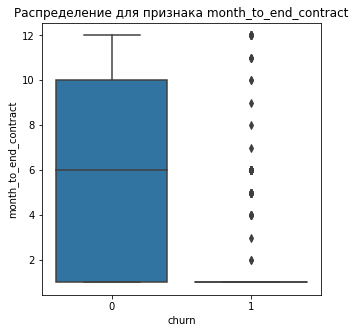

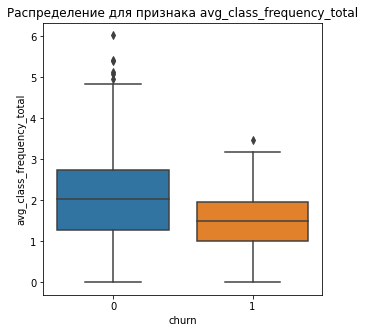

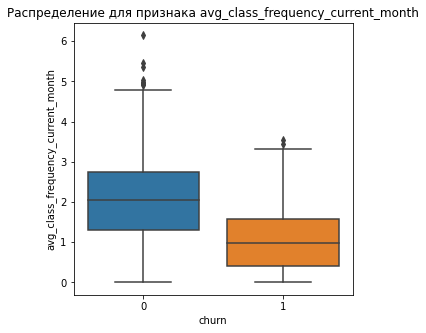

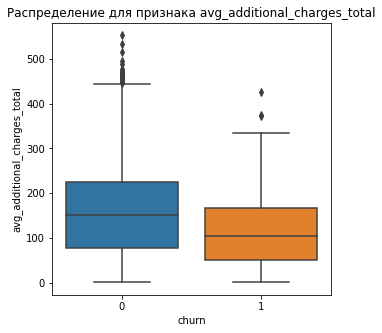

In [10]:
for feature in ['age', 'lifetime', 'contract_period', 'month_to_end_contract', \
               'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']:
    plt.figure(figsize=(5,5))
    plt.title("Распределение для признака " + feature)
    sns.boxplot(x='churn', y=gym_churn[feature], data=gym_churn)
    plt.show()

**Посмотрим на основные статистические показатели количественных признаков. Посчитаем среднее и медианное количество, дисперсию и стандартное отклонение для количественных признаков**

In [11]:
desc_stat_churn = gym_churn.pivot_table(index=['churn'],
                  values=['age', 'lifetime', 'contract_period', 'month_to_end_contract', 
                          'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total'], 
                  aggfunc={'age': [np.mean, np.median, np.std, np.var], 
                           'lifetime': [np.mean, np.median, np.std, np.var], 
                           'contract_period': [np.mean, np.median, np.std, np.var],
                           'month_to_end_contract': [np.mean, np.median, np.std, np.var],
                           'avg_class_frequency_total': [np.mean, np.median, np.std, np.var],
                           'avg_class_frequency_current_month': [np.mean, np.median, np.std, np.var],
                           'avg_additional_charges_total': [np.mean, np.median, np.std, np.var]})
desc_stat_churn.T

churn                                          0       1
age                               mean     29.98   26.99
                                  median   30.00   27.00
                                  std       3.01    2.90
                                  var       9.06    8.38
avg_additional_charges_total      mean    158.45  115.08
                                  median  149.88  103.81
                                  std      99.80   77.70
                                  var    9960.36 6036.73
avg_class_frequency_current_month mean      2.03    1.04
                                  median    2.05    0.98
                                  std       1.02    0.77
                                  var       1.04    0.59
avg_class_frequency_total         mean      2.02    1.47
                                  median    2.04    1.49
                                  std       1.02    0.69
                                  var       1.03    0.48
contract_period                   mean      5.75    1.73
                                  median    6.00    1.00
                                  std       4.72    2.13
                                  var      22.25    4.55
lifetime                          mean      4.71    0.99
                                  median    4.00    1.00
                                  std       3.87    1.11
                                  var      15.01    1.23
month_to_end_contract             mean      5.28    1.66
                                  median    6.00    1.00
                                  std       4.36    1.96
                                  var      19.04    3.86

Чаще уходят клиенты, которые:
* живут или работают дальше от фитнес-центра;
* реже являются сотрудниками компаний-партнеров;
* реже приходят по программе «приведи друга»;
* моложе;
* реже посещают групповые занятия;
* у них меньше прошло времени с первого обращения в фитнес-центр;
* меньше длительность их текущего абонемента и меньше срок до его окончания;
* они реже посещали фитнес-центре в неделю за предыдущий месяц и у них меньше посещений в неделю за все время;
* тратят меньше на другие услуги фитнес-центра (кафе, спорттовары, косметический и массажный салон).

Можно предположить, что к признакам, которые не влияют на отток можно отнести пол, контактный телефон.

По основным статистическим показателям, у большинства количественных признаков стандартное отклонение не превышает среднего значения, это говорит о том, что серьезных аномалий или выбросов не наблюдаются. Однако, выделяются такие признаки как contract_period, lifetime и month_to_end_contract, у которых в оттоке наблюдаются незначительные выбросы, но это не критично и их присутствие не повлияет на результаты анализа.

### Построим матрицу корреляций и отобразим ее

**Для выявления коррелирующих признаков построим матрицу корреляции с помощью метода .corr()**

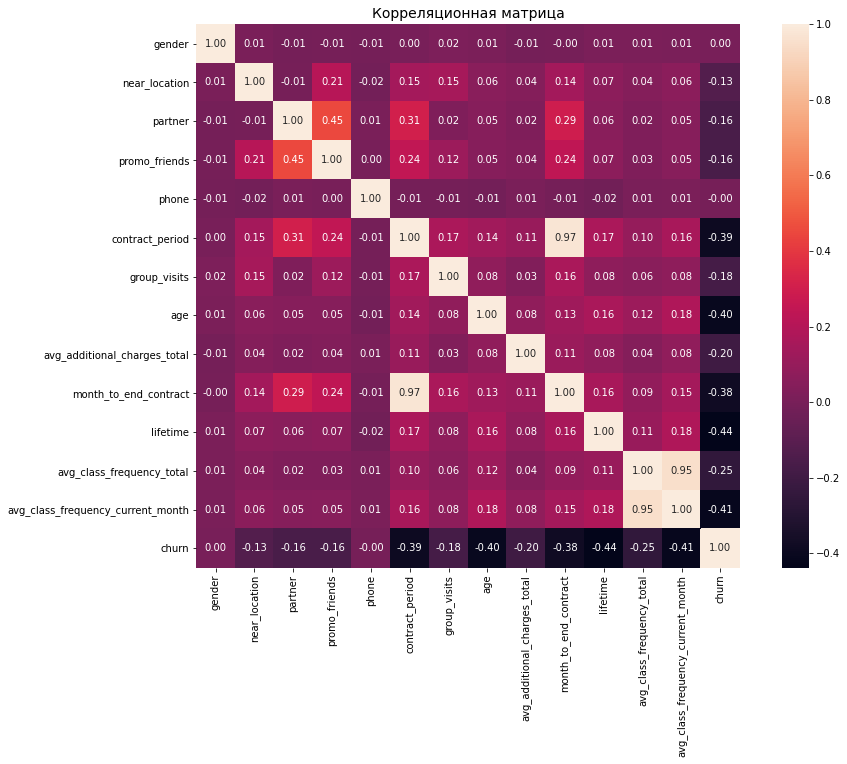

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(data=gym_churn.corr(), annot=True, square=True, fmt='.2f')
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

Явной взаимозависимости факта оттока (churn целевая переменная) с признаками не обнаружено, но есть взаимозависимость фактора оттока с признаком lifetime (время с момента первого обращения в фитнес-центр), коэффициент корреляции равен -0.44, то есть чем меньше прошло времени с момента первого обращения в фитнес-центр, тем выше вероятность того, что клиент попадет в отток.

Далее по значимости следуют средняя частота посещений клуба за предыдущий месяц (коэффициент корреляции равен -0.41), возраст (коэффициент корреляции равен -0.40), длительность текущего действующего абонемента (коэффициент корреляции равен -0.39) и срок до истечения текущего действующего абонемента (коэффициент корреляции равен -0.38). Для остальных признаков характерна очень слабая корреляция с целевой переменной. Пол и контактный телефон не влияют на отток.

Между собой сильно коррелируют две пары признаков:
* contract_period (длительность текущего действующего абонемента) и month_to_end_contract (срок до окончания текущего действующего абонемента), коэффициента корреляции равен 0.97);
* аvg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) и аvg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц), коэффициент корреляции равен 0.95.

Сильная положительная корреляция между contract_period и month_to_end_contract (97%) очевидна, так как чем длиннее изначальный срок абонемента, тем в среднем больше месяцев до окончания контракта остается у пользователей. Сильная положительная корреляция между признаками avg_class_frequency_total и avg_class_frequency_current_month (95%) объяснима тем, что эти метрики характеризует одно и то же, но за разные периоды. Скорее всего клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра.

Наблюдается проблема частичной мультиколлинеарности. Мультиколлинеарность возникает, когда есть группа линейно зависимых признаков — взаимозависимых или очень сильно скоррелированных (часто коэффициент корреляции больше 0.8).

Также видим заметную относительно остальных корреляцию между признаком partner (сотрудник компании-партнера клуба) и признаком promo_friends (факт первоначальной записи в рамках акции «приведи друга»), коэффициент корреляции равен 0.45. То есть, вероятно, клиенты, пришедшие в клуб по партнерской программе, решили сделать это за компанию со своими коллегами, прислав им промо-код для оплаты первого абонемента. Видим и заметную относительно остальных корреляцию между признаком contract_period (длительность текущего действующего абонемента) и partner (сотрудник компании-партнера клуба), коэффициент корреляции равен 0.31. Возможно, фитнес-центр дает таким клиентам хорошую скидку, и они покупают более длительный абонемент.

In [13]:
# чтобы избавиться от мультиколлинеарности, удалим из датафрейма одну из пар:
gym_churn.drop('month_to_end_contract', axis = 1, inplace = True)

gym_churn.shape

(4000, 13)

Можно сравнить качество моделей до и после удаления признаков и выбрать оптимальный вариант.

**Вывод**

По результатам исследовательского анализа получили следующую информацию о данных:

1. Портрет среднего клиента:
* мужчина или женщина;
* проживает или работает в районе, где находится фитнес-центр;
* скорее не является сотрудниками компании-партнера клуба;
* пришел не по программе «приведи друга»;
* нам известен его контактный телефон;
* не посещает групповые занятия;
* средний возраст 29 лет;
* среднее время с момента первого обращения в фитнес-центр почти 4 месяца;
* средняя длительность текущего действующего абонемента 4 месяца
* средний срок до окончания текущего действующего абонемента 4 месяца.
* средняя частота посещений в неделю за все время с начала действия абонемента 2 раза.
* средняя частота посещений в неделю за предыдущий месяц 2 раза.
* средняя суммарная выручка, которую клиент принес финес-центру, от других услуг (кафе, спорттовары, косметический и массажный салон) равна 147 у.е.

Доля оттока составляет 27%.

2. Клиенты, которые чаще уходят, имеют следующие характеристики:
* живут или работают дальше от фитнес-центра;
* реже являются сотрудниками компаний-партнеров;
* реже приходят по программе «приведи друга»;
* они моложе;
* реже посещают групповые занятия;
* у них меньше прошло времени с первого обращения в фитнес-центр;
* меньше длительность их текущего абонемента и меньше срок до его окончания;
* они реже посещали фитнес-центре в неделю за предыдущий месяц и у них меньше посещений в неделю за все время;
* тратят меньше на другие услуги фитнес-центра (кафе, спорттовары, косметический и массажный салон).

3. По результатам построения корреляционной матрицы мы получили, что явной взаимозависимости факта оттока с признаками не обнаружено. Однако есть взаимозависимость фактора оттока с признаком lifetime (время с момента первого обращения в фитнес-центр), коэффициент корреляции равен -0.44, то есть чем меньше прошло времени с момента первого обращения в фитнес-центр, тем выше вероятность того, что клиент попадет в отток.

Далее по значимости следуют: 
* avg_class_frequency_current_month (средняя частота посещений фитнес-центра за предыдущий месяц), коэффициент корреляции равен -0.41;
* age (возраст), коэффициент корреляции равен -0.40;
* contract_period (длительность текущего действующего абонемента), коэффициент корреляции равен -0.39;
* month_to_end_contract (срок до истечения текущего действующего абонемента), коэффициент корреляции равен -0.38.


Для остальных признаков характерна очень слабая корреляция с целевой переменной.

При этом между собой сильно коррелируют две пары признаков:
* contract_period (длительность текущего действующего абонемента) и month_to_end_contract (срок до окончания текущего действующего абонемента), коэфициент корреляции равен 0.97);
* аvg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) и аvg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц), коэффициент корреляции равен 0.95.

Поэтому чтобы избавиться от мультиколлинеарности мы убрали один признак из пары - month_to_end_contract (срок до окончания текущего действующего абонемента), что положительно повлияло на метрики моделей для прогнозирования оттока.

## Шаг 3. Построим модель прогнозирования оттока клиентов

Для построения модели прогнозирования оттока клиентов будем использовать следующие модели бинарной классификации:
* логистическая регрессия - Logistic Regression
* модель случайного леса - Random Forest Classifier

### Разбьем данные на обучающую и валидационную выборку функцией train_test_split()

In [14]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

# разделим данные на обучающую 80% train и валидационную 20% test выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом

**Логистическая регрессия - Logistic Regression**

In [15]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

**Случайный лес - Random Forest Classifier**

In [16]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_depth=12, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

Для оценки качества полученных прогнозов и выбора лучшей модели сравним следующие метрики:
* Accuracy: доля правильных ответов. Чем ближе к единице, тем лучше.
* Precision: отражает точность модели. Чем ближе к единице, тем лучше.
* Recall: полнота модели. Чем ближе к единице, тем лучше.
* F1-мера: сводная метрика, которая объединяет бы в себе информацию о точности и полноте нашего алгоритма. Чем ближе к единице, тем лучше.
* ROC AUC: метрика оценки качества классификатора. Чем ближе к единице, тем лучше.

In [17]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = "Метрики классификации"):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba))) 

# выведем все метрики для модели логистической регрессии и модели случайного леса
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.79
	F1: 0.81
	ROC_AUC: 0.97


Модель логистической регрессии в нашем случае показала результаты лучше:
* доля правильных ответов (accuracy) выше у модели логической регрессии (92% против 91%);
* точность (precision) выше у модели логической регрессии (85% против 83%);
* полнота (recall) выше у модели логической регрессии (83% против 79%);
* F1-мера выше у модели логической регрессии (84% против 81%);
* доля оценки качества классификатора (ROC AUC) одинакова для обеих моделей - 97%.

**Вывод**

При построении модели мы разделили выборку на обучающую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены 2 модели: алгоритмом логистической регрессии и алгоритмом случайного леса.

Основные метрики полученных моделей следующие. Для модели логистической регрессии:
* Accuracy = 0.92; 
* Precision = 0.85; 
* Recall = 0.83; 
* F1 = 0.84; 
* ROC_AUC = 0.97. 


Для модели случайного леса: 
* Accuracy = 0.91; 
* Precision = 0.83; 
* Recall = 0.79; 
* F1 = 0.81; 
* ROC_AUC = 0.97. 

Таким образом, обе модели достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрегирующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC AUC.

## Шаг 4. Сделаем кластеризацию клиентов

### Стандартизируем данные

In [18]:
# создим объект класса Scaler (нормализатор)
scaler = StandardScaler()

# обучим нормализатор и преобразуем набор данных. Без churn целевой переменной
X_st = scaler.fit_transform(X)

### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим какое количество кластеров можно выделить

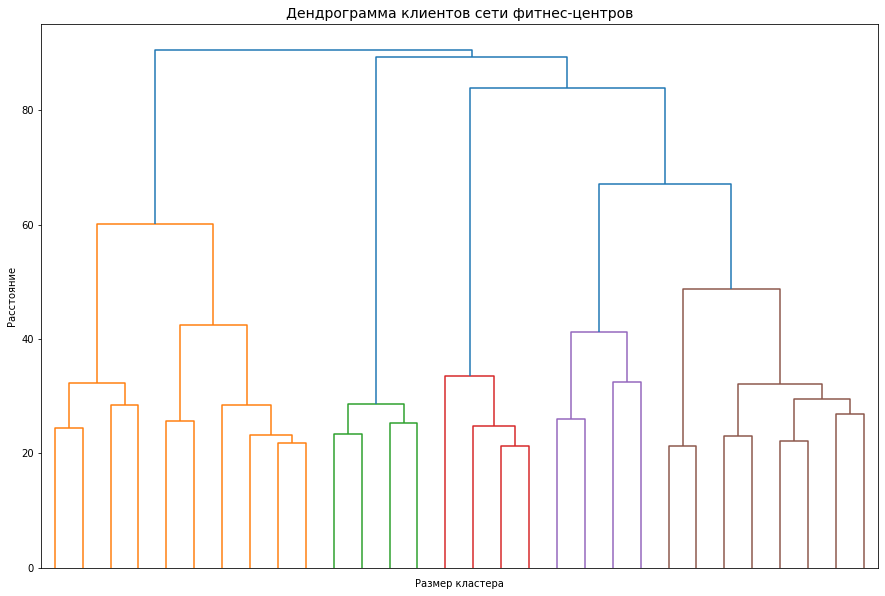

In [19]:
# расчитаем матрицу расстояний с помощью метода linkage
linked = linkage(X_st, method = 'ward')

# построим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', show_leaf_counts=False, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=14)
plt.title("Дендрограмма клиентов сети фитнес-центров", fontsize=14)
plt.xlabel("Размер кластера")
plt.ylabel("Расстояние")
plt.show()

Мы имеем 5 разных цветов на графике, предложенное оптимальное число кластеров - 5.

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров возьмем n=5.

Алгоритм K-Means группирует пошагово все объекты. Вот принцип его работы:
* Есть K кластеров. Алгоритм пошагово подбирает их центры и относит объекты к тому кластеру, чей центр ближе.
* Центры корректируются (меняют свое положение) до тех пор, пока это позволяет минимизировать среднее расстояние от объектов каждого кластера до его центра.
* Когда расстояние от объектов до центра перестает снижаться или сокращается несущественно, алгоритм останавливается и фиксирует разбиение, считая его оптимальным.

**Выполним кластеризацию по алгоритму K-Means**

In [20]:
# зададим число кластеров равное 5
k_means = KMeans(n_clusters = 5, random_state=1)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = k_means.fit_predict(X_st)

# присвоим каждому наблюдению в датафрейме соответствующее значение кластера 
gym_churn['cluster_km'] = labels

### Посмотрим на средние значения признаков для кластеров. Ответим на вопрос: можно ли сразу что-то заметить?

**Выведем статистику по средним значениям признаков по кластеру**

In [21]:
cluster_means = gym_churn.groupby(['cluster_km']).mean().T
cluster_means

cluster_km,0,1,2,3,4
gender,0.57,0.49,0.52,0.48,0.49
near_location,0.97,1.00,0.86,0.99,0.00
partner,0.31,0.24,0.47,0.95,0.49
promo_friends,0.10,0.10,0.31,0.88,0.07
phone,1.00,1.00,0.00,1.00,1.00
contract_period,5.17,2.49,4.76,7.81,2.86
group_visits,0.49,0.33,0.43,0.54,0.23
age,30.28,28.22,29.28,29.63,28.57
avg_additional_charges_total,166.03,131.43,144.24,154.89,136.30
lifetime,5.00,2.44,3.92,4.46,2.91


**Кластер 0 характеризуется:**
* чуть большим числом людей одного пола, по сравнению с другим;
* 97% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 31% клиентов являются сотрудниками компании-партнера клуба (partner);
* 10% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 5 месяца (contract_period);
* 49% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 30 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 166 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 5 месяцев (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента почти 3 раза (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц почти 3 раза (avg_class_frequency_current_month).

Доля оттока 4% (самый низкий отток).


**Кластер 1 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами (gender);
* 100% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 24% клиентов являются сотрудниками компании-партнера клуба (partner);
* 10% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 2 месяца (contract_period);
* 33% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 28 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 131 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 2 месяцев (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента 1 раз (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц 1 раз (avg_class_frequency_current_month).

Доля оттока 50% (самый высокий отток).


**Кластер 2 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами (gender);
* 86% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 47% клиентов являются сотрудниками компании-партнера клуба (partner);
* 31% клиентов пришли по программе «приведи друга» (promo_friends);
* не имеем в наличии контактные телефоны (phone);
* средняя длительность текущего действующего абонемента 4 месяца (contract_period);
* 43% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 29 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 144 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 4 месяцев (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента почти 2 раза (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц почти 2 раза (avg_class_frequency_current_month).

Доля оттока 27%.


**Кластер 3 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами (gender);
* 99% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 95% клиентов являются сотрудниками компании-партнера клуба (partner);
* 88% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 7 месяца (contract_period);
* 54% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 29 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 154 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 4 месяца (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента почти 2 раза (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц почти 2 раза (avg_class_frequency_current_month).

Доля оттока 10%.


**Кластер 4 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами (gender);
* клиенты не проживают, не работают в районе, где находится фитнес-центр (near_location);
* 49% клиентов являются сотрудниками компании-партнера клуба (partner);
* 7% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 3 месяца (contract_period);
* 23% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 28 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 136 у.е. (avg_additional_charges_total).
* среднее время с момента первого обращения в фитнес-центр 3 месяца (lifetime).
* средняя частота посещений в неделю за все время с начала действия абонемента 1 раз (avg_class_frequency_total).
* средняя частота посещений в неделю за предыдущий месяц 1 раз (avg_class_frequency_current_month).

Доля оттока 42%.

### Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?

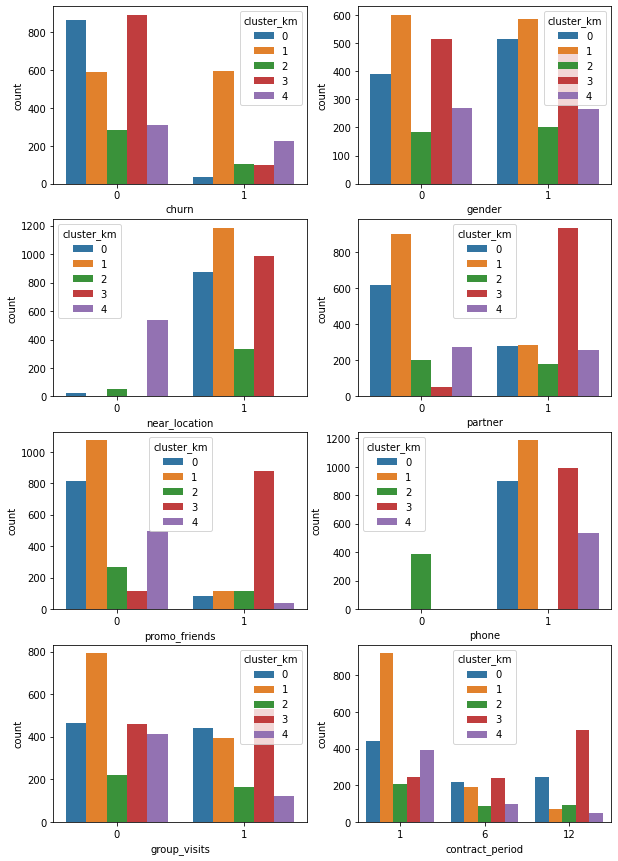

In [22]:
# список с бинарными признаками
list_1 = ['churn', 'gender', 'near_location', 'partner', 
       'promo_friends', 'phone', 'group_visits', 'contract_period'] 

# цикл для построения графиков
fig, ax = plt.subplots(4,2,figsize=(10,15))
for axis,column in zip(ax.flat,list_1):
    sns.countplot(x=gym_churn[column], hue=gym_churn['cluster_km'], ax=axis)

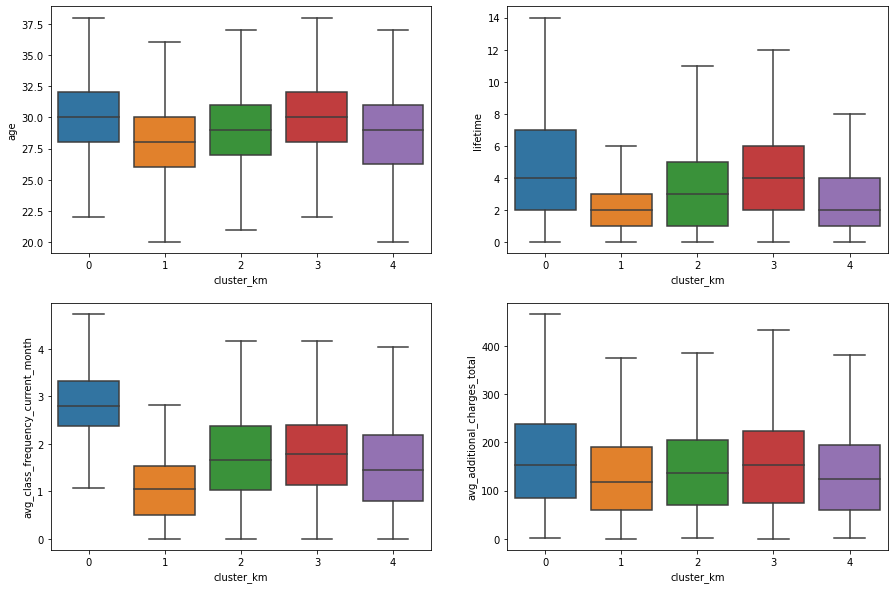

In [23]:
# список с количественными признаками
list_2 = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total'] 

# цикл для построения графиков
fig, ax = plt.subplots(2,2,figsize=(15,10))

for axis,column in zip(ax.flat,list_2):
    sns.boxplot(x=gym_churn['cluster_km'], y=gym_churn[column], ax=axis, showfliers=False)

По графикам видим, что чаще всего уходят клиенты первого кластера, которые:
* проживают или работают в районе, где находится фитнес-центр;
* реже являются сотрудниками компании-партнера клуба;
* реже приходят по программе «приведи друга»;
* в основном покупают абонемент на месяц;
* реже посещают групповые занятия;
* средний возраст клиентов 28 лет;
* тратят на другие услуги (кафе, спорттовары, косметический и массажный салон) меньше, чем клиенты остальных групп;
* меньше остальных провели время в фитнес-центре;
* реже посещают зал в неделю за все время и за предыдущий месяц (1 раз);

Самые хорошие показатели у кластера 0, на них нужно ориентироваться. У них самая низкая доля оттока, они тратят больше чем другие клиенты, проводят больше времени в фитнес-центре и контрактный период у них достаточно долгий.

### Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надежны?

In [24]:
# для каждого полученного кластера посчитаем долю оттока
gym_churn_grouped = gym_churn.groupby('cluster_km').mean().reset_index()[['cluster_km', 'churn']]
gym_churn_grouped['ratio_churn'] = (gym_churn_grouped['churn'] * 100).round(2)
gym_churn_grouped[['cluster_km', 'ratio_churn']].sort_values(by='ratio_churn', ascending=False)

,cluster_km,ratio_churn
1,1,50.17
4,4,41.95
2,2,26.75
3,3,10.18
0,0,4.21


Кластеры, которые склонны к оттоку, это следующие:
* кластер 1 с вероятностью 50%
* кластер 4 с вероятностью 42%
* кластер 2 с вероятностью 27%
* кластер 3 с вероятностью 10% - является надежным
* кластер 0 с вероятностью 4% - является самым надежным

**Вывод**

После стандартизации данных была построена матрица расстояний и дендрограмма, затем было принято решение для прогноза кластеров клиентов использовать пять кластеров в модели K-Means.

Анализ средних значений и распределений признаков для кластеров показал, что выделенные нами кластеры имеют следующие характеристики.

**Кластер 0 характеризуется:**
* чуть большим числом людей одного пола, по сравнению с другим;
* 97% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 31% клиентов являются сотрудниками компании-партнера клуба (partner);
* 10% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 5 месяца (contract_period);
* 49% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 30 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 166 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 5 месяцев (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента почти 3 раза (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц почти 3 раза (avg_class_frequency_current_month).

**Кластер 1 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами;
* 100% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 24% клиентов являются сотрудниками компании-партнера клуба (partner);
* 10% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 2 месяца (contract_period);
* 33% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 28 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 131 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 2 месяцев (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента 1 раз (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц 1 раз (avg_class_frequency_current_month).

**Кластер 2 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами;
* 86% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 47% клиентов являются сотрудниками компании-партнера клуба (partner);
* 31% клиентов пришли по программе «приведи друга» (promo_friends);
* не имеем в наличии контактные телефоны (phone);
* средняя длительность текущего действующего абонемента 4 месяца (contract_period);
* 43% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 29 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 144 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 4 месяцев (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента почти 2 раза (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц почти 2 раза (avg_class_frequency_current_month).

**Кластер 3 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами;
* 99% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 95% клиентов являются сотрудниками компании-партнера клуба (partner);
* 88% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 7 месяца (contract_period);
* 54% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 29 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 154 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 4 месяца (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента почти 2 раза (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц почти 2 раза (avg_class_frequency_current_month).

**Кластер 4 характеризуется:**
* приблизительно равным распределением между мужчинами и женщинами;
* клиенты не проживают, не работают в районе, где находится фитнес-центр (near_location);
* 49% клиентов являются сотрудниками компании-партнера клуба (partner);
* 7% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 3 месяца (contract_period);
* 23% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 28 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 136 у.е. (avg_additional_charges_total).
* среднее время с момента первого обращения в фитнес-центр 3 месяца (lifetime).
* средняя частота посещений в неделю за все время с начала действия абонемента 1 раз (avg_class_frequency_total).
* средняя частота посещений в неделю за предыдущий месяц 1 раз (avg_class_frequency_current_month).

Первый кластер больше всего склонен к оттоку: доля составляет 50%. Четвертый кластер характеризуется долей оттока в 42%, а второй - около 27%. Нулевой и третий кластеры (доля оттока 4% и 10% соответственно) являются самыми надежными.

## Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

### Выводы

Заказчик подготовил для нас данные клиентов за предыдущий до проверки факта оттока месяц, информацию на основе журнала посещений, покупок, а также информация о текущем статусе абонемента. Эти данные содержат в себе информацию о 4000 клиентов и 14 показателях, один из которых (отток клиентов) был выбран в модели в качестве результирующего. 

В качестве показателей, которые влияют на отток, мы рассмотрели следующие характеристики клиентов: пол, проживание или работа в районе, где находится фитнес-центр, принадлежность к компании-партнеру, факт первоначальной записи в рамках акции «приведи друга», наличие контактного телефона, возраст, время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, срок до окончания действующего абонемента, факт посещения групповых занятий, средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарная выручка от других услуг фитнес-центра.

**I. По результатам исследовательского анализа получили следующую информацию о данных:**

**1.Портрет среднего клиента:**
* мужчина или женщина;
* проживает или работает в районе, где находится фитнес-центр;
* скорее не является сотрудниками компании-партнера клуба;
* пришел не по программе «приведи друга»;
* нам известен его контактный телефон;
* не посещает групповые занятия;
* средний возраст 29 лет;
* среднее время с момента первого обращения в фитнес-центр почти 4 месяца;
* средняя длительность текущего действующего абонемента 4 месяца
* средний срок до окончания текущего действующего абонемента 4 месяца.
* средняя частота посещений в неделю за все время с начала действия абонемента 2 раза.
* средняя частота посещений в неделю за предыдущий месяц 2 раза.
* средняя суммарная выручка, которую клиент принес финес-центру, от других услуг (кафе, спорттовары, косметический и массажный салон) равна 147 у.е.

Доля оттока составляет 27%.

**2.Клиенты, которые чаще уходят, имеют следующие характеристики:**
* живут или работают дальше от фитнес-центра;
* реже являются сотрудниками компаний-партнеров;
* реже приходят по программе «приведи друга»;
* они моложе;
* реже посещают групповые занятия;
* у них меньше прошло времени с первого обращения в фитнес-центр;
* меньше длительность их текущего абонемента и меньше срок до его окончания;
* они реже посещали фитнес-центре в неделю за предыдущий месяц и у них меньше посещений в неделю за все время;
* они тратят меньше на другие услуги фитнес-центра (кафе, спорттовары, косметический и массажный салон).

**3. По результатам построения корреляционной матрицы** мы получили, что явной взаимозависимости факта оттока с признаками не обнаружено. Однако есть взаимозависимость фактора оттока с признаком lifetime (время с момента первого обращения в фитнес-центр), коэффициент корреляции равен -0.44, то есть чем меньше прошло времени с момента первого обращения в фитнес-центр, тем выше вероятность того, что клиент попадет в отток.

Далее по значимости следуют: 
* avg_class_frequency_current_month (средняя частота посещений фитнес-центра за предыдущий месяц), коэффициент корреляции равен -0.41;
* age (возраст), коэффициент корреляции равен -0.40;
* contract_period (длительность текущего действующего абонемента), коэффициент корреляции равен -0.39;
* month_to_end_contract (срок до истечения текущего действующего абонемента), коэффициент корреляции равен -0.38. 

Для остальных признаков была характерна очень слабая корреляция с целевой переменной.

**II. По результатам построения модели прогнозирования оттока клиентов:**

Были созданы две модели прогнозирования оттока клиентов - на основе алгоритмов логистической регрессии и случайного леса. Для оценки качества полученных прогнозов и выбора лучшей модели мы сравнили их по метрикам.

Основные метрики полученных моделей следующие. **Для модели логистической регрессии:**
* Accuracy = 0.92; 
* Precision = 0.85; 
* Recall = 0.83; 
* F1 = 0.84; 
* ROC_AUC = 0.97. 


**Для модели случайного леса:**
* Accuracy = 0.91; 
* Precision = 0.83; 
* Recall = 0.79; 
* F1 = 0.81; 
* ROC_AUC = 0.97. 

Таким образом, и модель логистической регрессии, и модель случайного леса способны достаточно хорошо делать прогноз. Модель логистической регрессии подходит нам больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрегирующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC AUC.

**III. По результатам кластеризации клиентов:**

Первый кластер больше всего склонен к оттоку: доля составляет 50%. Четвертый кластер характеризуется долей оттока в 42%, а второй - около 27%. Нулевой и третий кластеры (доля оттока 4% и 10% соответственно) являются самыми надежными.

**Чаще всего уходят клиенты первого кластера, которые:**
* проживают или работают в районе, где находится фитнес-центр;
* реже являются сотрудниками компании-партнера клуба;
* реже приходят по программе «приведи друга»;
* в основном покупают абонемент на месяц;
* реже посещают групповые занятия;
* средний возраст клиентов 28 лет;
* тратят на другие услуги (кафе, спорттовары, косметический и массажный салон) меньше, чем клиенты остальных групп;
* меньше остальных провели время в фитнес-центре;
* реже посещают зал в неделю за все время и за предыдущий месяц (1 раз);

Самые хорошие показатели у нулевого кластера, на них нужно ориентироваться. У них самая низкая доля оттока, они тратят больше чем другие клиенты, проводят больше времени в фитнес-центре и контрактный период у них достаточно долгий.

**Кластер 0 характеризуется:**
* чуть большим числом людей одного пола, по сравнению с другим;
* 97% клиентов проживают или работают в районе, где находится фитнес-центр (near_location);
* 31% клиентов являются сотрудниками компании-партнера клуба (partner);
* 10% клиентов пришли по программе «приведи друга» (promo_friends);
* наличие контактного телефона у 100% клиентов (phone);
* средняя длительность текущего действующего абонемента 5 месяца (contract_period);
* 49% клиентов посещают групповые занятия (group_visits);
* средний возраст клиентов 30 лет (age);
* средняя суммарная выручка от других услуг фитнес-центра 166 у.е. (avg_additional_charges_total);
* среднее время с момента первого обращения в фитнес-центр 5 месяцев (lifetime);
* средняя частота посещений в неделю за все время с начала действия абонемента почти 3 раза (avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц почти 3 раза (avg_class_frequency_current_month).

### Базовые рекомендации для стратегии взаимодействия с клиентами и их удержания

**В первую очередь следует обратить внимание на следующие признаки, влияющие на отток:**

* Посещаемость в текущем месяце - это один из самых точных индикаторов того, что клиент вероятно покинет фитнес-клуб, схожий по смыслу признак - средняя частота посещений в неделю за все время также имеет значение, поэтому следует отслеживать одну из этих метрик и прикладывать усилия по ее увеличению, чтобы сократить отток, потому что у надежных кластеров (нулевой и третий) частота посещений достигает 2-3 раза в неделю, в то время как у кластеров с наибольшим оттоком (первый и четвертый) - 1 раз. Можно мотивировать не пропускать занятия или вернуться в фитнес-центр, если клиент уже их пропускает - через смс, предлагать бонусы за регулярность и частоту. Например, организовывать челленджи и дарить подарки за их прохождение, делать скидки на продолжительные абонементы/занятия с тренером, как награду за регулярное посещение фитнес-клуба. Также можно предложить "заморозить" действующий абонемент, если клиент устал или не может ходить сейчас по каким-либо причинам, а потом пригласить его вернуться обратно.


* Увеличить lifetime можно за счет маркетинговых активностей. Например, подарить клиенту сертификат на массаж при покупке абонемента на следующий месяц, что может не только повлиять на отток (среднее время с момента первого обращения в фитнес-центр выше в кластерах с наименьшим оттоком), но и увеличить выручку, если клиентам понравятся услуги и они начнут больше тратить (необходимо изучить ценовую политику). Также можно запустить акцию и при покупке абонемента на 12 месяцев дарить составление программы тренировок с питанием, дать скидку в кафе или на спорт-товары (или другие услуги нашего фитнес-центра). Можно привлекать клиентов на групповые занятия (акции, пробные занятия, качественная доступная рекламная информация по каждому направлению тренировок), что улучшит среди них нетворкинг и уменьшит отток, так как в надежных кластерах (нулевой и третий) посещение групповых занятий выше. При этом регулярно мониторить и собирать данные, можно разделить пользователей на когорты и для групп, при пересечении некой "отметки", после которой мы уже можем считать пользователей лояльными, делать на время предложение по специальной цене, чтобы они оставались с нами. Также можно провести отдельное исследование о том сколько людей впервые посетившие фитнес-клуб покупают следующий абонемент, возможно, что часть клиентов берут абонементы "попробовать", тогда нужно максимально вовлечь эту аудиторию в жизнь клуба.


* Чтобы увеличить длительность действующего абонемента клиентам можно также предлагать льготные условия по продлению абонемента, причем стремиться продлить договор на максимально возможный срок, потому что надежные кластерный (нулевой и третий) характеризуются высокими значениями длительности текущего действующего абонемента, в то время как кластеры с наибольшим оттоком (первый и четвертый) имеют наименьшие значения.


* Наименее лояльные клиенты в группах, где средний возраст в которых ниже 30 лет, поэтому необходимо выявить является ли это общеотраслевой тенденцией, если да, то изучить решение этой проблемы в отрасли и рассмотреть возможность внедрения этих решений в нашем фитнес-клубе. Если проблема характерна для нашего клуба, то необходимо провести исследование на предмет важных факторов, которые могут влиять на отток. Например, есть ли у нашего клуба приложение, онлайн расписание и запись, оплата, предлагаем ли мы "модные" направления (кроссфит, йога, воркаут), делаем ли скидки студентам.


Также можно глубже сегментировать клиентов, к каждому сегменту сделать индивидуальное предложение. Менеджеры еще могут  обзвонить людей и понять причины их редкой посещаемости, чтобы сформировать более качественное предложение или разработать новые программы для тренировок. Для наиболее перспективных кластеров (нулевого и третьего) тоже необходимо разработать стратегию, у них достаточно мотивации чтобы ходить, но можно сделать им подарки или дать бонус за приведенного друга. При этом наличие телефона и гендерная принадлежность не влияют на вероятность оттока, но наличие этих данных позволит более качественно работать с потенциальными клиентами, путем информирования о новых продуктах, скидках и акциях. Более детально следует изучить запушенные акции «приведи друга» и акции для сотрудников компании-партнера, а также есть ли у нас маркетинговые затраты на рекламу в районе фитнес-центра, чтобы скорректировать и эффективно перераспределить бюджет.